In [103]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import pickle

# Exploration

In [2]:
data1 = pd.read_csv("data/measurements.csv")
data1.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [3]:
data2 = pd.read_excel("data/measurements2.xlsx")
data2.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


In [4]:
data1.shape, data2.shape

((388, 12), (388, 12))

In [5]:
data1.dtypes

distance         object
consume          object
speed             int64
temp_inside      object
temp_outside      int64
specials         object
gas_type         object
AC                int64
rain              int64
sun               int64
refill liters    object
refill gas       object
dtype: object

In [6]:
data2.dtypes

distance         float64
consume          float64
speed              int64
temp_inside      float64
temp_outside       int64
specials          object
gas_type          object
AC                 int64
rain               int64
sun                int64
refill liters    float64
refill gas        object
dtype: object

We will use data2 as it has the correct data types

# Cleaning

In [7]:
def clean_cols(df):
    
    df2 = df.copy()

    # Standarization of column names with snake_case, using lowercase and "_" as a separator
    cols = [col.lower().replace(" ", "_") for col in df2.columns]
    df2.columns = cols
                      
    return df2

In [76]:
data = clean_cols(data2)
data.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,ac,rain,sun,refill_liters,refill_gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


In [77]:
data.isna().sum()

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
ac                 0
rain               0
sun                0
refill_liters    375
refill_gas       375
dtype: int64

In [78]:
# We can drop this columns as it is already encoded in the next ones
data["specials"].value_counts(dropna=False)

NaN                   295
rain                   32
sun                    27
AC rain                 9
ac                      8
AC                      6
snow                    3
sun ac                  3
AC snow                 1
half rain half sun      1
AC sun                  1
AC Sun                  1
ac rain                 1
Name: specials, dtype: int64

In [79]:
data.drop(columns = "specials", inplace = True)

In [80]:
data.isna().sum()

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
gas_type           0
ac                 0
rain               0
sun                0
refill_liters    375
refill_gas       375
dtype: int64

In [81]:
data["temp_inside"].value_counts(dropna=False)

21.5    133
22.0    102
22.5     59
20.0     25
21.0     13
23.0     13
NaN      12
25.0     12
24.5      7
20.5      4
24.0      3
23.5      2
25.5      2
19.0      1
Name: temp_inside, dtype: int64

In [82]:
# As it's only a few rows we can drop them
data = data[data["temp_inside"].notna()]

In [83]:
data.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,ac,rain,sun,refill_liters,refill_gas
0,28.0,5.0,26,21.5,12,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,E10,0,0,0,NaN,NaN


# Feature Extraction

The refill columns are a special case, as they have valuable meaning but are not really usable for us, what we are going to do is some feature extraction by calculating how much each trip costs.

In order to do this, we need the price of each liter of gas, and how much the car consumed for that trip, thankfully with some exploration in the Kaggle page we know the prices:

- E10 = 1.38€
- SP98 = 1.46€

In [84]:
data.drop(columns = ["refill_liters", "refill_gas"], inplace = True)

In [85]:
def trip_cost(df):
    df2 = df.copy()
    df2["liters_trip"] = df2["distance"]/100*df2["consume"]
    df2["gas_price"] = df2["gas_type"].apply(lambda x: 1.38 if x == "E10" else 1.46)
    df2["trip_cost"] = df2["gas_price"]*df2["liters_trip"]
    df2["cost_km"] = df2["trip_cost"]/df2["distance"]
        
    return df2

In [86]:
data = trip_cost(data)
data.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,ac,rain,sun,liters_trip,gas_price,trip_cost,cost_km
0,28.0,5.0,26,21.5,12,E10,0,0,0,1.4000,1.38,1.932000,0.06900
1,12.0,4.2,30,21.5,13,E10,0,0,0,0.5040,1.38,0.695520,0.05796
2,11.2,5.5,38,21.5,15,E10,0,0,0,0.6160,1.38,0.850080,0.07590
3,12.9,3.9,36,21.5,14,E10,0,0,0,0.5031,1.38,0.694278,0.05382
4,18.5,4.5,46,21.5,15,E10,0,0,0,0.8325,1.38,1.148850,0.06210


In [101]:
# Now, thanks to this feature engineering we can extract the mean cost per km for each gas.
data.groupby(["gas_type"]).agg({"cost_km":"mean", "consume":"mean"})

# As we can see, E10 is the most cost-effective fuel, despite consuming more than SP98!

,cost_km,consume
gas_type,,
E10,0.068323,4.950955
SP98,0.071640,4.906849


In [88]:
# It doesn't look like much, but this means that for every 1000 km we are saving:
gas = data.groupby(["gas_type"]).agg({"cost_km":"mean"})
round((gas.iloc[1][0]-gas.iloc[0][0])*1000,2)
# 3 WHOLE euros!

3.32

# Visualization

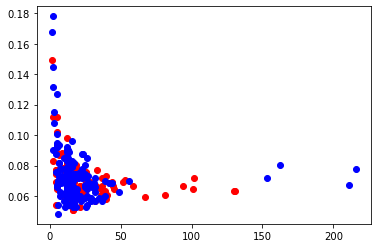

In [89]:
# We can clearly see here that the shorter the trip, the higher the costs per km.

plt.scatter(data["distance"][data["gas_type"] == "E10"], data["cost_km"][data["gas_type"] == "E10"], color = "red")
plt.scatter(data["distance"][data["gas_type"] == "SP98"], data["cost_km"][data["gas_type"] == "SP98"], color = "blue")

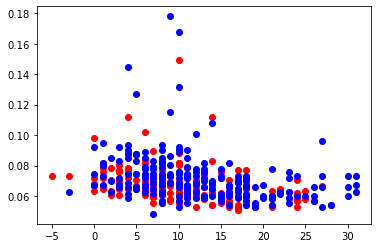

In [90]:
# Temperature outside doesn't seem too relevant, it looks like the car consumes more when is colder outside.

plt.scatter(data["temp_outside"][data["gas_type"] == "E10"], data["cost_km"][data["gas_type"] == "E10"], color = "red")
plt.scatter(data["temp_outside"][data["gas_type"] == "SP98"], data["cost_km"][data["gas_type"] == "SP98"], color = "blue")

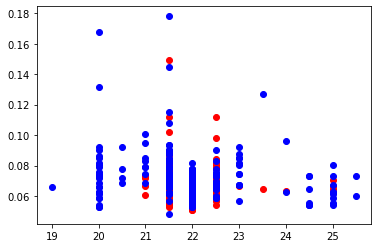

In [91]:
# Temperature inside seems similar in distribution to the outside temperature.

plt.scatter(data["temp_inside"][data["gas_type"] == "E10"], data["cost_km"][data["gas_type"] == "E10"], color = "red")
plt.scatter(data["temp_inside"][data["gas_type"] == "SP98"], data["cost_km"][data["gas_type"] == "SP98"], color = "blue")

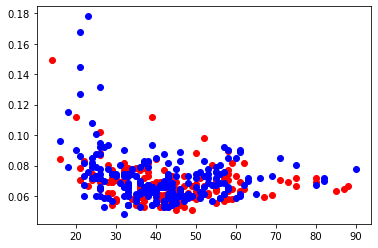

In [92]:
# Speed looks a bit relevant but we have to take into account that it is probably highly correlated with distance, as the mean speed will increase in highways.

plt.scatter(data["speed"][data["gas_type"] == "E10"], data["cost_km"][data["gas_type"] == "E10"], color = "red")
plt.scatter(data["speed"][data["gas_type"] == "SP98"], data["cost_km"][data["gas_type"] == "SP98"], color = "blue")

In [93]:
# Let's look now to some conditions

In [94]:
# With AC on, both fuels consume more.
data.groupby(["gas_type", "ac"]).agg({"cost_km":"mean"})

cost_km
gas_type ac          
E10      0   0.068218
         1   0.070577
SP98     0   0.070966
         1   0.077380

In [95]:
# Rain makes the const skyrocket.
data.groupby(["gas_type", "rain"]).agg({"cost_km":"mean"})

cost_km
gas_type rain          
E10      0     0.067307
         1     0.077280
SP98     0     0.069948
         1     0.081901

In [96]:
# A sunny day enough to warm the car lowers the costs.
data.groupby(["gas_type", "sun"]).agg({"cost_km":"mean"})

cost_km
gas_type sun          
E10      0    0.068820
         1    0.061724
SP98     0    0.072582
         1    0.062269

# Predictions

The predictions that we could do are limited, as some data is obtanied AFTER doing the trip, but we might want to know how much the trip will cost BEFORE doing it. In this case, we are going to try to predict the cost/km of a trip where we know distance, gas, and conditions.

In [ ]:
data_pred = data

In [47]:
# First let's encode our gas types

data_pred["gas_type"] = data["gas_type"].apply(lambda x: 1 if x == "E10" else 0)

In [48]:
# Now let's drop some columns that we can't use

data_pred.drop(columns = ["consume", "speed", "liters_trip", "gas_price", "trip_cost", "gas_price"], inplace = True)

In [50]:
# X/y split

X = data_pred.drop(columns = "cost_km")
y = data_pred["cost_km"]

In [51]:
def hist_maker(df):
    
    cols = list(df.columns)
    x = len(cols)
    fig, ax = plt.subplots(1,x, figsize=(20,10))

    for col in cols:
        y = cols.index(col)
        sns.histplot(data=df, x=col, ax = ax[y])
        ax[y].set_title(col)
        
    return

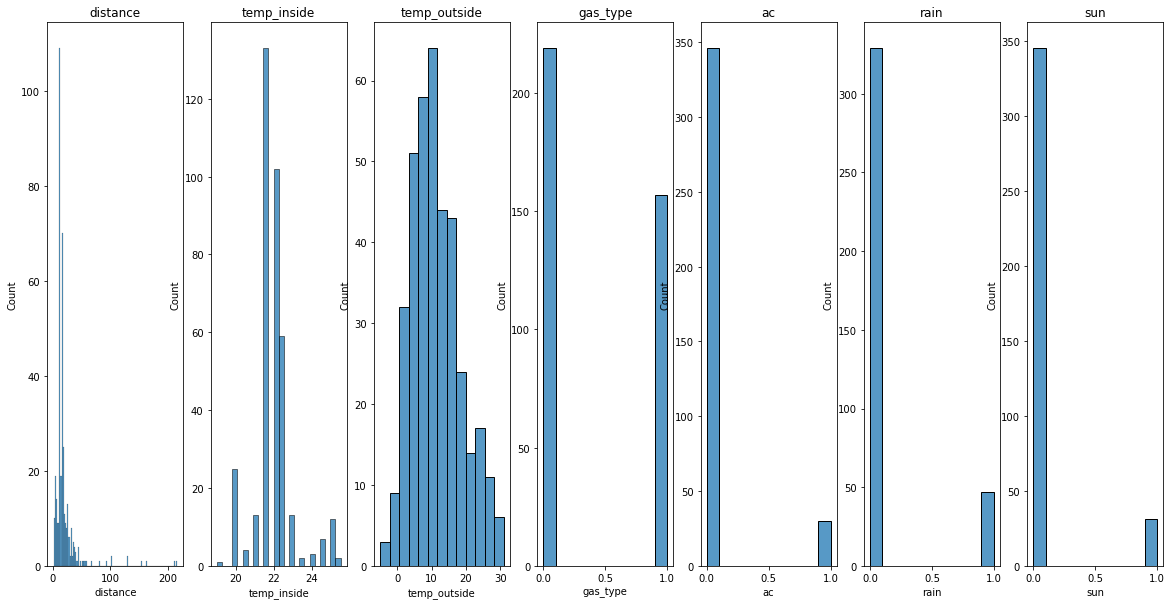

In [52]:
# Checking dristributions

hist_maker(X)

In [58]:
# Train/Test split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.22, random_state = 22)

In [59]:
# Let's transform these columns to make the distribution better.

X_train_num = X_train[["distance", "temp_inside", "temp_outside"]]
X_test_num = X_test[["distance", "temp_inside", "temp_outside"]]

In [62]:
trans = PowerTransformer()

X_train_num_trans = trans.fit_transform(X_train_num)
X_train_num_trans = pd.DataFrame(X_train_num_trans, columns = X_train_num.columns, index = X_train_num.index)

X_test_num_trans = trans.transform(X_test_num)
X_test_num_trans = pd.DataFrame(X_test_num_trans, columns = X_test_num.columns, index = X_test_num.index)

In [63]:
# Also important to scale all the values.

scaler = MinMaxScaler()

X_train_num_scaled = scaler.fit_transform(X_train_num_trans)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num_trans.columns, index = X_train_num_trans.index)

X_test_num_scaled = scaler.transform(X_test_num_trans)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns = X_test_num_trans.columns, index = X_test_num_trans.index)

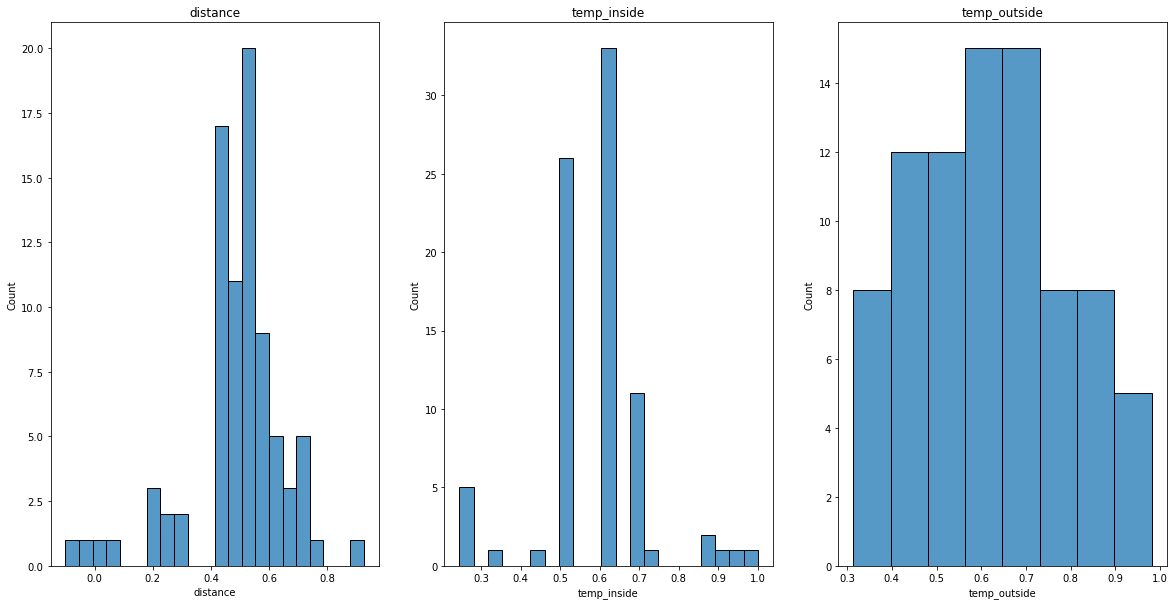

In [102]:
hist_maker(X_test_num_scaled)

In [64]:
X_train[["distance", "temp_inside", "temp_outside"]] = X_train_num_scaled
X_test[["distance", "temp_inside", "temp_outside"]] = X_test_num_scaled

In [68]:
# Let's try a Random Forest Regressor for the predictions.

rfr = RandomForestRegressor()

max_depth_choices = [2,3,4,5,6,7,8,9,10]
min_samples_split_choices = [2,3,4,5,6,7,8,9,10]
criterion_choices = ["squared_error", "absolute_error"]

grid_rfr = {'max_depth': max_depth_choices,
        'min_samples_split': min_samples_split_choices,
        "criterion" : criterion_choices}

In [71]:
grid_search_rfr = GridSearchCV(estimator = rfr, param_grid = grid_rfr, cv = 10)

In [72]:
grid_search_rfr.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [74]:
# Quite low score, this could be due to the quality of the data or that it its too hard for the model to predict the price without knowing other parameters such as speed and consume.

print(grid_search_rfr.best_params_)
print(grid_search_rfr.best_score_)
rfrgs = grid_search_rfr.best_estimator_

{'criterion': 'absolute_error', 'max_depth': 9, 'min_samples_split': 2}
0.4044058533855782


# Conclusions

The most cost-effective fuel is the ```E10``` by a small margin.

The car consumes less when the AC is off in a warm day without rain. Lower temperatures make the costs higher.

Short trips are more costly per km than longer trips, speed plays a factor as well.

Predicting the cost of a trip is quite hard as some of the values needed are obtained after completing the trip, thus making the prediction pointless.

## Saving data for a future use

In [99]:
data.to_csv("data/data.csv")

In [104]:
filename = "transformer.pkl"
with open(filename, "wb") as file:
    pickle.dump(trans, file)

In [105]:
filename = "scaler.pkl"
with open(filename, "wb") as file:
    pickle.dump(scaler, file)

In [106]:
filename = "model.pkl"
with open(filename, "wb") as file:
    pickle.dump(rfrgs, file)

# Front End

Done with Streamlit, just run the